**Problem Statement: Forecasting stock prices of National Stock Exchange** 

### Topics Covered
**1) VAR**

**2) ARCH**

**3) GARCH**

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import datetime as ds

import pandas_datareader as pdr
import datetime as dt

In [2]:
# fetching the stock price of NSEI between Jan 1st 2019 and August 13th 2021.
start = dt.datetime(2019,1,1)
end = dt.datetime(2021,8,13)

data_temp = pdr.data.get_data_yahoo('^NSEI', start, end, interval='d')

In [3]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 643 entries, 2019-01-02 to 2021-08-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       643 non-null    float64
 1   Low        643 non-null    float64
 2   Open       643 non-null    float64
 3   Close      643 non-null    float64
 4   Volume     643 non-null    float64
 5   Adj Close  643 non-null    float64
dtypes: float64(6)
memory usage: 35.2 KB


In [34]:
data_temp.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [4]:
# Considering the Close Price
ts_data = pd.DataFrame()
ts_data['Price'] = data_temp['Close']

In [18]:
# here could see that the data captured is only on business days
# As the market closes on Saturday and Sunday, 
# the Value stays the same as Friday on these days
# so using Forward Fill to fill the values
ts_data = ts_data.asfreq('d',method='ffill')

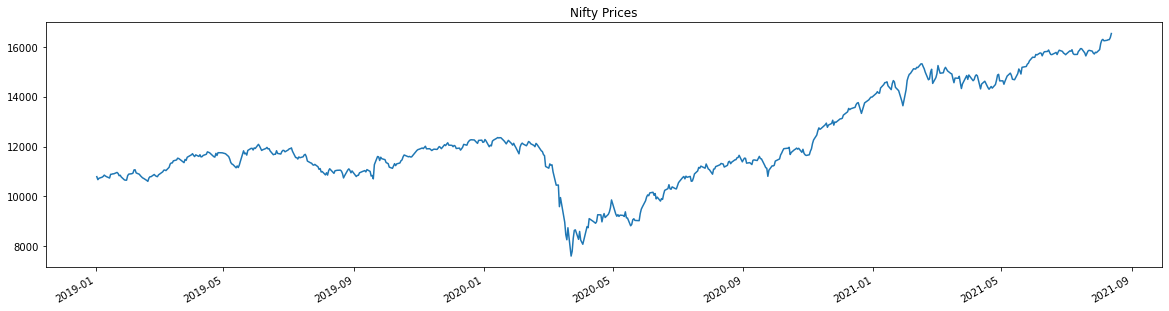

In [22]:
plt.figure(figsize= (20,5))
ts_data.Price.plot()
plt.title("Nifty Prices")
plt.xlabel('')
plt.show()

In [23]:
# Extracting the month  and year information
ts_data['year'] = pd.DatetimeIndex(ts_data.index).year.values
ts_data['month'] = pd.DatetimeIndex(ts_data.index).month.values

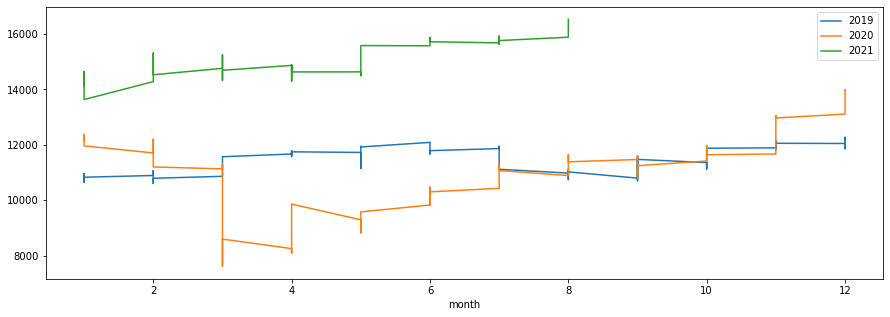

In [25]:
# ploting the year by values
fig, axes = plt.subplots(figsize = (15,5))
for year in range(2019,2022):
    
    df_temp = ts_data[['Price','month']][ts_data.year == year]
    
    df_temp.plot(x = 'month', y = 'Price',ax = axes, label = year)
 
plt.legend(loc = 'upper right')
plt.show()

# Could see that 2021 is outperforming the other years. Also could see in the 3rd and 4th month of 2020, could see a drop.

**Train Test Split**

In [12]:
# Taking the last two months as test
test_ts_data = ts_data[ts_data.index > dt.datetime(2021,6,13)][['Price']]

In [13]:
# taking from the start to two months ago as train.
ts_data = ts_data[ts_data.index < dt.datetime(2021,6,13)][['Price']]

#### Stationarity Test

In [28]:
from statsmodels.tsa.stattools import adfuller

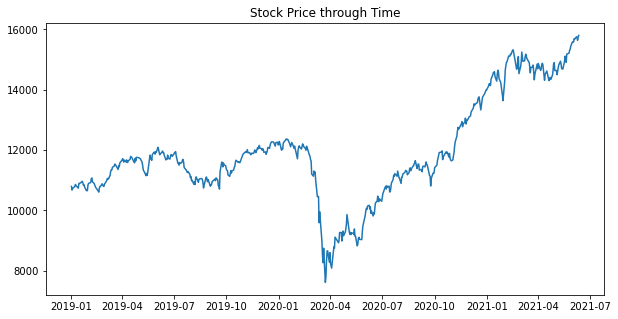

In [29]:
plt.figure(figsize = (10,5))
plt.plot(ts_data['Price'])
plt.title('Stock Price through Time')
plt.show()

# Could see that clearly the stock is not stationary.

In [30]:
# Indexing the Data
ts_data = ts_data[['Price']]

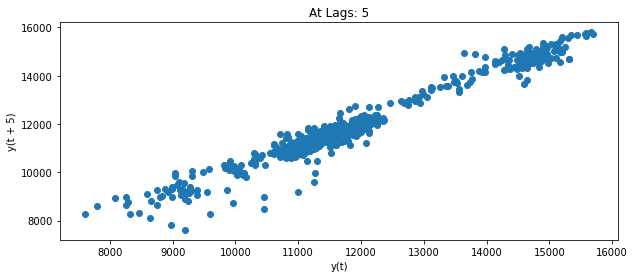

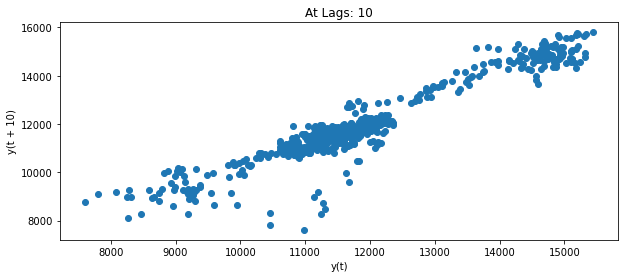

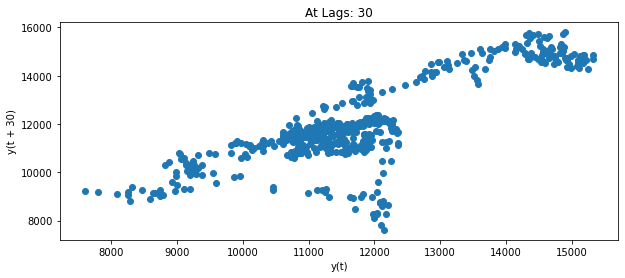

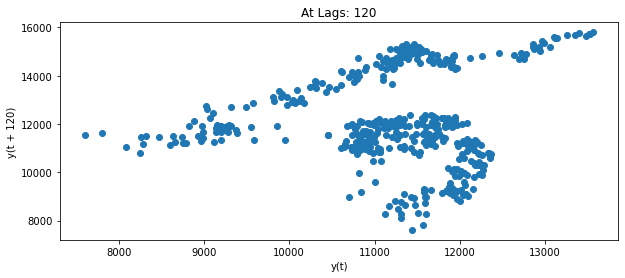

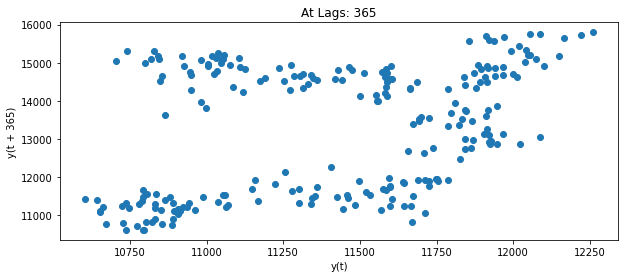

In [53]:
from pandas.plotting import lag_plot

lags = [5,10,30,120,365]

for i in lags:
    
    plt.figure(figsize=(10,4))
    lag_plot(ts_data['Price'], lag=i)
    plt.title("At Lags: %s"%i)
    plt.show()

# Could see a strong linear correlation at 5 and as we go back futher the relation infuses.

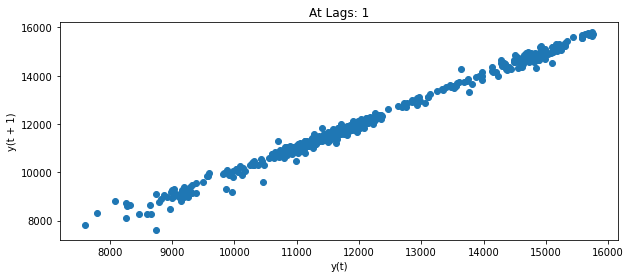

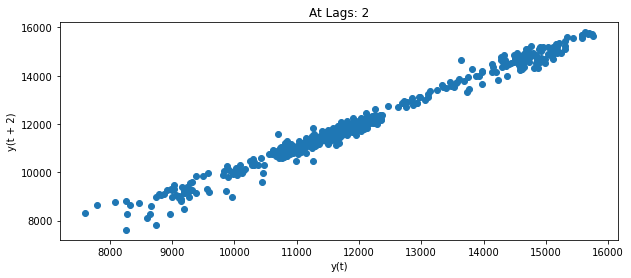

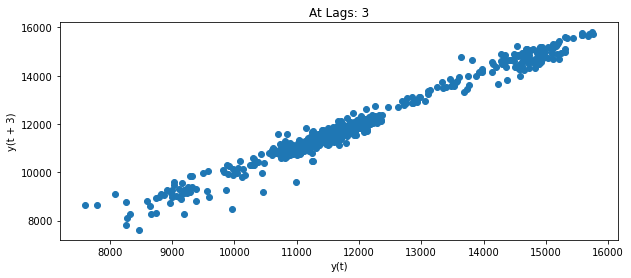

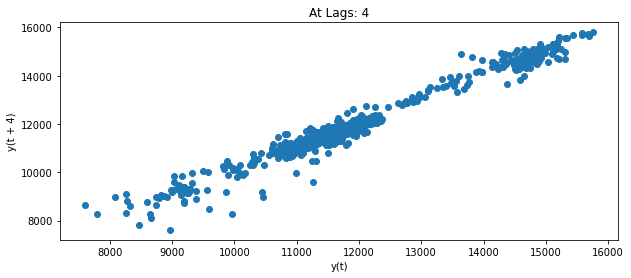

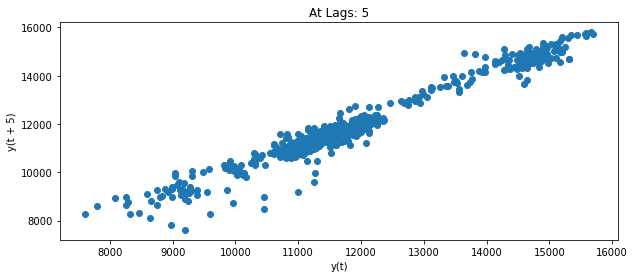

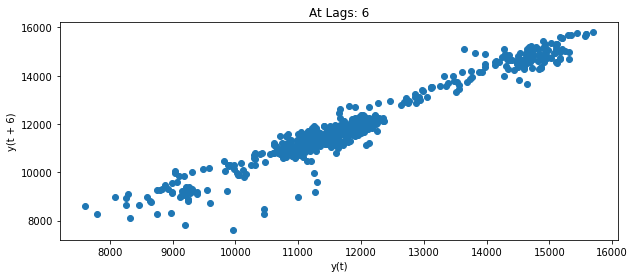

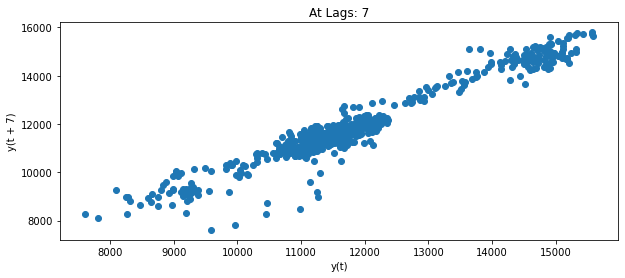

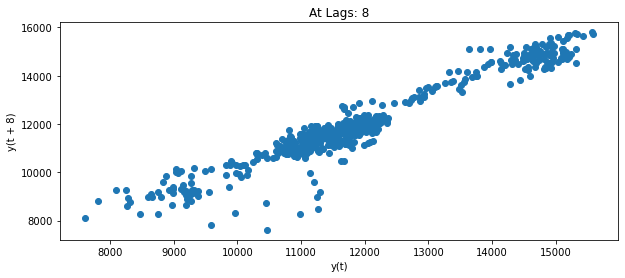

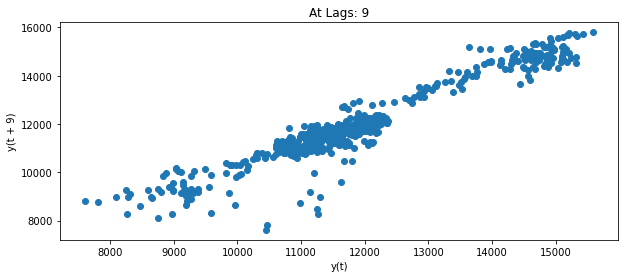

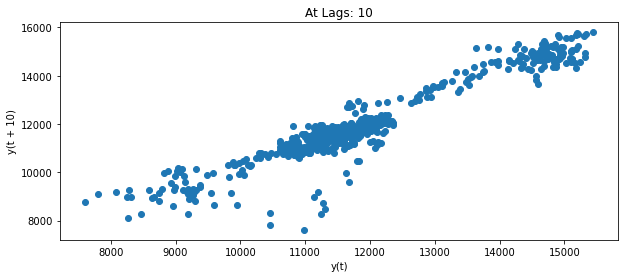

In [54]:
# So focusing the lags between 1 and 10
lags = range(1,11)

for i in lags:
    
    plt.figure(figsize=(10,4))
    lag_plot(ts_data['Price'], lag=i)
    plt.title("At Lags: %s"%i)
    plt.show()

# Could see that the linear correlation reducing as well as we move away.

#### Checking Augmented Dickey Fuller Testing for Stationarity

In [31]:
def stat_ad_fuller(tf):
    
    from statsmodels.tsa.stattools import adfuller

    test_output = adfuller(tf)

    print('ADF Statistic: ', test_output[0])

    print('p-value: ', test_output[1])

    print('Critial Values: ', test_output[4])

**Here as we have trend in the data we can do a differencing transformation**

**Using differencing**

In [35]:
# applying differencing to the dataframe
diff_ts_data = ts_data.diff(periods=1)[1:]

diff_ts_data = diff_ts_data[1:]

stat_ad_fuller(diff_ts_data)

ADF Statistic:  -8.14010447980152
p-value:  1.0336684252492228e-12
Critial Values:  {'1%': -3.4414821678603946, '5%': -2.8664511716874657, '10%': -2.5693855271473716}


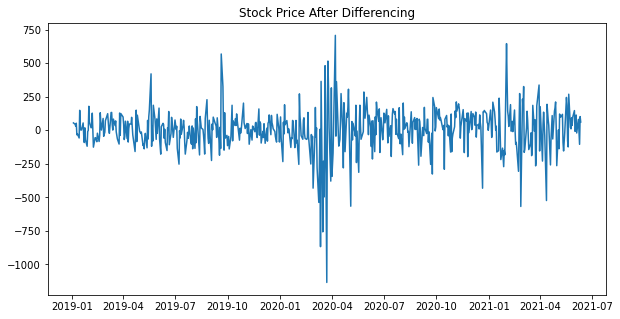

In [45]:
plt.figure(figsize = (10,5))
plt.plot(diff_ts_data['Price'])
plt.title('Stock Price After Differencing')
plt.show()

# Could see that even though the stock is stationarized, a lot of noise is in the data. Can can be due to the 
# Hetroskedascity of the data. But we need to check further before making any assumptions.

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

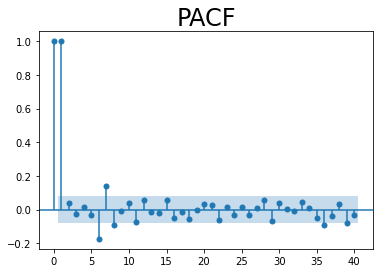

In [67]:
plot_pacf(ts_data,lags= 40,method = 'ols')
plt.title("PACF", size = 24)
plt.show()

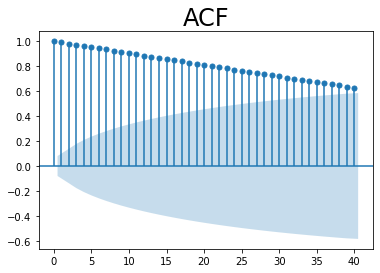

In [64]:
plot_acf(ts_data,lags= 40)
plt.title("ACF", size = 24)
plt.show()

**Using Auto-ARIMA Model**

In [71]:
# Import pmdarima for autoarima
from pmdarima import auto_arima

# From the lag plot could see that the seasonality is 5.
auto_arima(ts_data,max_p=3, max_d=3,max_q=3, m = 5,seasonal = True, trace=True, stepwise = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=7719.970, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=7749.177, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=7735.637, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=7737.348, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=7748.873, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=7743.019, Time=1.69 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=7717.913, Time=1.98 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=7755.684, Time=0.41 sec
 ARIMA(2,1,2)(2,0,0)[5] intercept   : AIC=7719.842, Time=3.55 sec
 ARIMA(2,1,2)(2,0,1)[5] intercept   : AIC=7722.348, Time=2.39 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=7739.285, Time=0.48 sec
 ARIMA(2,1,1)(1,0,0)[5] intercept   : AIC=7739.255, Time=0.58 sec
 ARIMA(3,1,2)(1,0,0)[5] intercept   : AIC=7718.961, Time=1.69 sec
 ARIMA(2,1,3)(1,0,0)[5] intercept   : AIC=7718.537, Time=1.42 sec
 ARIMA(1,1,1)(1,0,0)[5] intercept

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(1, 0, 0, 5),
      suppress_warnings=True, with_intercept=False)

In [72]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [116]:
predict_df = test_ts_data.copy()

In [155]:
# importing SARIMAX from stats models
from statsmodels.tsa.statespace.sarimax import SARIMAX
# the Order(p,d,q) helps us to implement all the models
# 0,1,0 means ARIMA(0,1,0) model
model = SARIMAX(ts_data, order=(2,1,2), seasonal_order=(1, 0, 0, 5))

result = model.fit()

forcast_values = result.forecast(len(test_ts_data))

predict_df['SARIMA'] = forcast_values.values

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                  599
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 5)   Log Likelihood               -3852.036
Date:                            Fri, 13 Aug 2021   AIC                           7716.073
Time:                                    20:09:48   BIC                           7742.434
Sample:                                         0   HQIC                          7726.336
                                            - 599                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4694      0.021    -71.125      0.000      -1.510      -1.429
ar.L2         -0.9236      0.019    -48.486      0.000      -0.961      -0.886
ma.L1          1.4606      0.015     98.783      0.000       1.432       1.490
ma.L2          0.9694      0.015     65.760      0.000       0.940       0.998
ar.S.L5        0.1404      0.032      4.436      0.000       0.078       0.203
sigma2      2.252e+04    727.110     30.967      0.000    2.11e+04    2.39e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               975.86
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

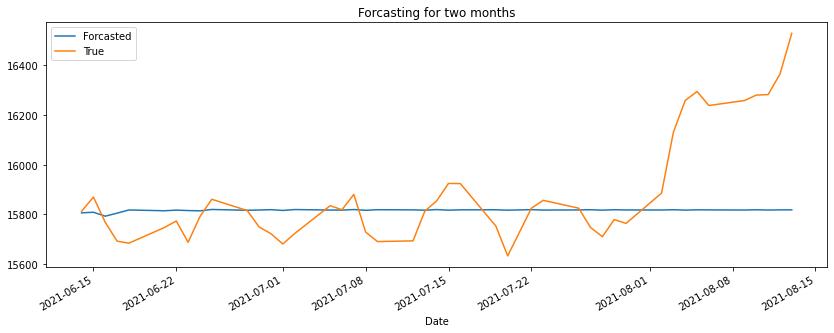

In [118]:
plt.figure(figsize = (14,5))

predict_df['SARIMA'].plot(label = 'Forcasted')
predict_df['Price'].plot(label = 'True')

plt.title('Forcasting for two months')

plt.legend()
plt.show()

**Validation Metric**

In [91]:
from sklearn.metrics import mean_squared_error

In [119]:
np.sqrt(mean_squared_error(predict_df['Price'],predict_df['SARIMA']))

231.73753111456577

**Residual Plotting of ARIMA Model**

In [144]:
residuals = result.resid[1:]

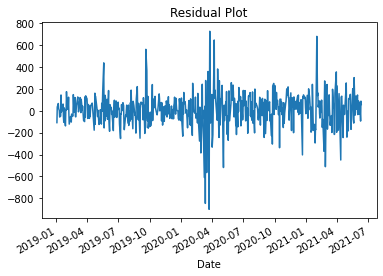

In [145]:
residuals.plot()

plt.title('Residual Plot')

plt.show()

#### Volatility Check

In [146]:
from statsmodels.stats.diagnostic import het_arch

archtest = het_arch(residuals)

print('p value is :',archtest[1])

p value is : 1.1796706841475213e-30


**As the Null hypothesis is rejected, we can say that the residuals show heteroscedastisity. SO we need to implement ARCH Models on the residuals**

In [169]:
# Creating a dataframe that contains all the residuals from the train and forecast
df_garch = pd.DataFrame()
df_garch['Resid'] = pd.concat([result.resid,(predict_df['Price'] - predict_df['SARIMA'])])

In [171]:
from arch import arch_model
# arch model is used with df_garch as input and vol as GRACH
model_arch = arch_model(df_garch, p = 2, q = 0, vol = "GARCH")

# the fitting is done only on the train set
arch_results = model_arch.fit(last_obs = test_ts_data.index[0],update_freq = 5)
arch_results.summary()

Iteration:      5,   Func. Count:     29,   Neg. LLF: 3852.238741810722
Iteration:     10,   Func. Count:     54,   Neg. LLF: 3849.638257531771
Iteration:     15,   Func. Count:     79,   Neg. LLF: 3849.636277771725
Iteration:     20,   Func. Count:    104,   Neg. LLF: 3849.402136384587
Iteration:     25,   Func. Count:    129,   Neg. LLF: 3835.5464677898626
Iteration:     30,   Func. Count:    157,   Neg. LLF: 3810.779016644973
Iteration:     35,   Func. Count:    184,   Neg. LLF: 3810.713046573169
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3810.713046573136
            Iterations: 35
            Function evaluations: 184
            Gradient evaluations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                  Resid   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                       ARCH   Log-Likelihood:               -3810.71
Distribution:                  Normal   AIC:                           7629.43
Method:            Maximum Likelihood   BIC:                           7647.01
                                        No. Observations:                  599
Date:                Fri, Aug 13 2021   Df Residuals:                      595
Time:                        20:15:41   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            13.3249      5.435      2.452  1.421e-02 [  2.673, 23.977]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega       8774.0391   1494.419      5.871  4.326e-09 [5.845e+03,1.170e+04]
alpha[1]       0.4396      0.188      2.340  1.931e-02   [7.133e-02,  0.808]
alpha[2]       0.3426      0.115      2.966  3.014e-03     [  0.116,  0.569]
============================================================================

Covariance estimator: robust
"""

In [244]:
# the values are forecasted and the residual variance values are obtained. 
predict_df['ARCH']  = arch_results.forecast().residual_variance.iloc[len(ts_data):]
# then the Standard deviation is calculated
predict_df['ARCH'] = np.sqrt(predict_df['ARCH'])

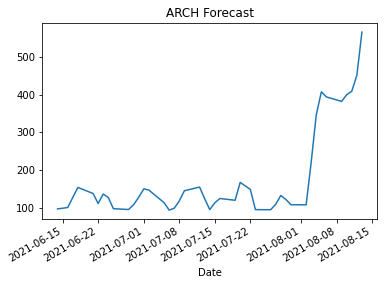

In [247]:
predict_df['ARCH'].plot()

plt.title('ARCH Forecast')

plt.show()

In [233]:
# Calcualting the intervals of the SARIMA with ARCH predictions
predict_df['ARCH +'] = predict_df['SARIMA'] + predict_df['ARCH']

predict_df['ARCH -'] = predict_df['SARIMA'] - predict_df['ARCH']

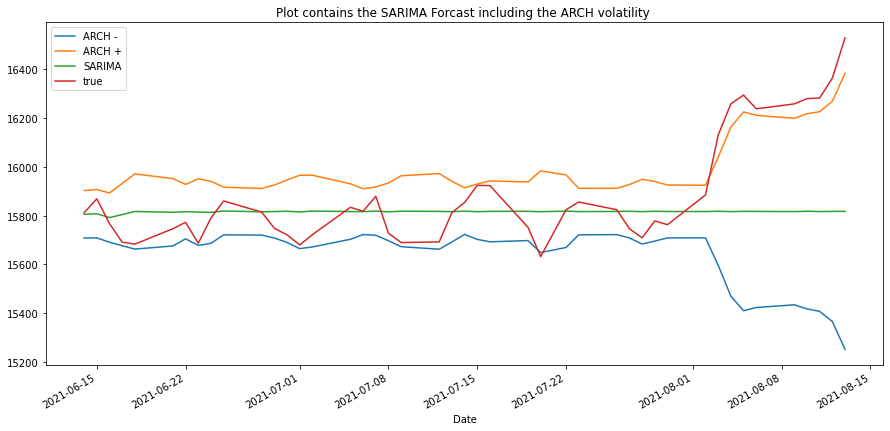

In [251]:
plt.figure(figsize=(15,7))

predict_df['ARCH -'].plot(label = 'ARCH -')
predict_df['ARCH +'].plot(label = 'ARCH +')
predict_df['SARIMA'].plot(label = 'SARIMA')
predict_df['Price'].plot(label = 'true')

plt.title('Plot contains the SARIMA Forcast including the ARCH volatility ')
plt.legend()

plt.show()

**Causuality**

In [18]:
# fetching the stock price of TCS
start = dt.datetime(2019,1,2)
end = dt.datetime(2021,8,13)

data_temp = pdr.data.get_data_yahoo('TCS.NS', start, end, interval='d')

**TCS Stock**

In [19]:
ts_data_tcs = pd.DataFrame()
ts_data_tcs['Price'] = data_temp['Close']

ts_data_tcs.Price.fillna(method = 'ffill', inplace=True)

test_ts_data_tcs = ts_data_tcs[ts_data_tcs.index > dt.datetime(2021,6,13)]

ts_data_tcs = ts_data_tcs[ts_data_tcs.index < dt.datetime(2021,6,13)]

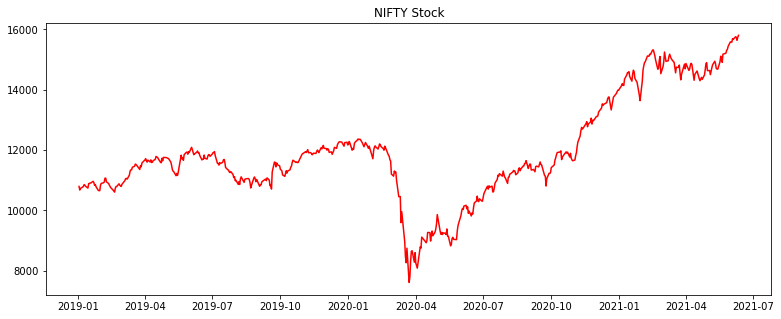

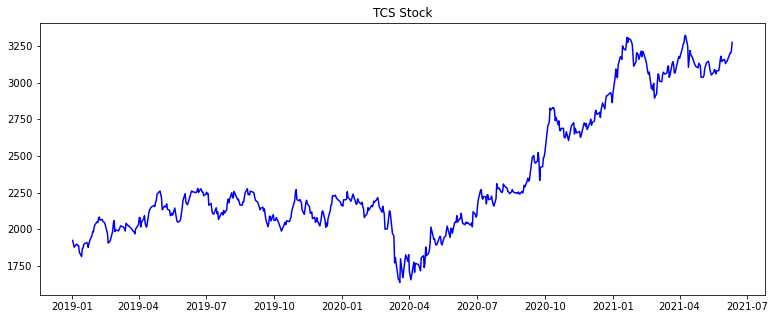

In [20]:
plt.figure(figsize=(13,5))
plt.plot(ts_data, label = 'NIFTY', color = 'Red')

plt.title('NIFTY Stock')

plt.figure(figsize=(13,5))

plt.plot(ts_data_tcs, label = 'TCS', color = 'Blue')

plt.title('TCS Stock')

plt.show()

In [21]:
for index in ts_data_tcs.index:
    
    if index in ts_data.index:
        continue
    else:
        print(index)

2021-01-01 00:00:00


In [22]:
# Dropping this row as this is not present in NIFTY Data
ts_data_tcs = ts_data_tcs[ts_data_tcs.index != dt.datetime(2021,1,1)]

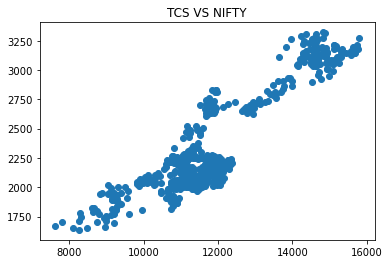

In [23]:
plt.scatter(ts_data,ts_data_tcs)

plt.title('TCS VS NIFTY')
plt.show()

In [313]:
 from statsmodels.tsa.stattools import grangercausalitytests

In [314]:
causuality_df = pd.DataFrame()

causuality_df['NIFTY_price'] = ts_data.Price
causuality_df['TCS_price'] = ts_data_tcs.Price

In [315]:
granger_output = grangercausalitytests(causuality_df, maxlag = 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2743  , p=0.0391  , df_denom=595, df_num=1
ssr based chi2 test:   chi2=4.2958  , p=0.0382  , df=1
likelihood ratio test: chi2=4.2805  , p=0.0386  , df=1
parameter F test:         F=4.2743  , p=0.0391  , df_denom=595, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7043  , p=0.0035  , df_denom=592, df_num=2
ssr based chi2 test:   chi2=11.5049 , p=0.0032  , df=2
likelihood ratio test: chi2=11.3954 , p=0.0034  , df=2
parameter F test:         F=5.7043  , p=0.0035  , df_denom=592, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1742  , p=0.0061  , df_denom=589, df_num=3
ssr based chi2 test:   chi2=12.6716 , p=0.0054  , df=3
likelihood ratio test: chi2=12.5387 , p=0.0057  , df=3
parameter F test:         F=4.1742  , p=0.0061  , df_denom=589, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.3198  , p=0.0105  

**Could see a granger casusality from the first lag**

**So we can use it in VAR Modelling**

**Checking for Stationarity**

In [316]:
stat_ad_fuller(ts_data_tcs)

ADF Statistic:  -0.36467704543434937
p-value:  0.9158314979487219
Critial Values:  {'1%': -3.4413325959192393, '5%': -2.86638530474078, '10%': -2.569350430308386}


In [317]:
# applying differentiation to the dataframe
diff_ts_data_tcs = ts_data_tcs.diff(periods=1)[1:]

diff_ts_data_tcs = diff_ts_data_tcs[1:]

stat_ad_fuller(diff_ts_data_tcs)

ADF Statistic:  -25.413481566016603
p-value:  0.0
Critial Values:  {'1%': -3.4413696108194607, '5%': -2.8664016052801906, '10%': -2.569359115918202}


**Could see that the TCS stock is stationarized with first order differentiation**

In [318]:
diff_causuality_df = pd.DataFrame()

diff_causuality_df['NIFTY_price'] = diff_ts_data.Price
diff_causuality_df['TCS_price'] = diff_ts_data_tcs.Price

**Now we can implement VAR Model**

In [319]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [320]:
model = VAR(causuality_df)

model_fit = model.fit(maxlags = 4)

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 13, Aug, 2021
Time:                     21:31:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    17.3864
Nobs:                     595.000    HQIC:                   17.3054
Log likelihood:          -6803.50    FPE:                3.11293e+07
AIC:                      17.2537    Det(Omega_mle):     3.02085e+07
--------------------------------------------------------------------
Results for equation NIFTY_price
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 52.953760        49.377774            1.072           0.284
L1.NIFTY_price         1.005254         0.047679           21.084           0.000
L1.TCS_price          -0.428995         0.184562  

In [322]:
# extracting the NIFTY forcast values
list_NIFTY = list()
for NIFTY, TCS in model_fit.forecast(causuality_df.values, steps = len(test_ts_data_tcs)):
    
    list_NIFTY.append(NIFTY)
    
predict_df['VAR'] = list_NIFTY

In [329]:
column_names = ['SARIMA','VAR', 'ARCH +']
rmse_list = list()
for column in column_names:
    
    rmse = np.sqrt(mean_squared_error(predict_df['Price'], predict_df[column]))
    
    rmse_list.append(rmse)

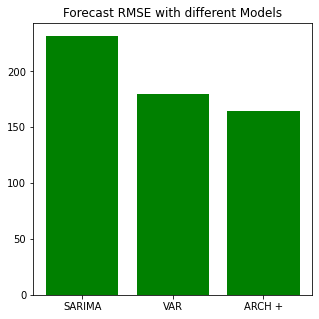

In [332]:
plt.figure(figsize=(5,5))

plt.bar(column_names,rmse_list, color = 'Green')

plt.title('Forecast RMSE with different Models')

plt.show()

**Could see that the ARCH with the SARIMA is outperforming the other models.**